# Test 18

Here is the deal.

Long quench + Long rotation

Compute everything.

Possibly cry at the end.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
#mpl.use('pgf')
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Global parameters

In [3]:
quench_time = 120*ureg.s
rotation_time = 300*ureg.s
total_time = quench_time + rotation_time
data_path = "../data/test18/"
runs = 10

params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":100e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":0.1*ureg.ms,
    "max_field":10*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)
params["size"] = 10

#locals().update(params)

In [4]:
def get_md_colloid(params,realization):
    sp = ice.spins()
    
    N = params["size"]
    a = params["lattice_constant"]
    
    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")

    particle = ice.particle(radius = params["particle_radius"],
                susceptibility = params["particle_susceptibility"],
                diffusion = params["particle_diffusion"],
                temperature = params["particle_temperature"],
                density = params["particle_density"])

    trap = ice.trap(trap_sep = params["trap_sep"],
                height = params["trap_height"],
                stiffness = params["trap_stiffness"])

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = params["height_spread"], 
                            susceptibility_spread = params["susceptibility_spread"],
                            periodic = params["isperiodic"])

        
    col.randomize()
    col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a


    world = ice.world(
            field = params["max_field"],
            temperature = params["sim_temp"],
            dipole_cutoff = params["sim_dipole_cutoff"],
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = f"./lammps_files/test{realization}",
                include_timestamp = False,
                targetdir = r".",
                framerate = params["framespersec"],
                timestep = params["dt"],
                run_time = params["total_time"],
                output = ["x","y","z","mux","muy","muz"],
                processors=1)

    # Field
    

    col.sim.field.fieldx = "v_Bmag*sin(PI/2/300*(time-120e6)/1e6)*(time>=120e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "v_Bmag/120e6*time*(time<120e6)+v_Bmag*cos(PI/2/300*(time-120e6)/1e6)*(time>=120e6)"        
        
    col.run_simulation()

    col.load_simulation()

    return col

In [5]:
def jesus_take_the_wheels(params,data_path,realization):
    trj_path = data_path + "/trj/"
    ctrj_path = data_path + "/ctrj/"

    try:
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass
    
    col = get_md_colloid(params,realization)

    filename = f"trj{realization}.csv"
    col.trj.to_csv(trj_path + filename)

    filename = f"ctrj{realization}.csv"
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv(ctrj_path + filename)
    
    return None

# MD shenanigans

In [6]:
import concurrent.futures

In [ ]:
runs = 10
realizations = list(range(1,runs+1))
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # map the function to the realizations
    results = list(
        executor.map(
            jesus_take_the_wheels,
            [params] * len(realizations),
            [data_path] * len(realizations),
            realizations,
        )
    )

This section graphs the fields just to check that everything is OK.

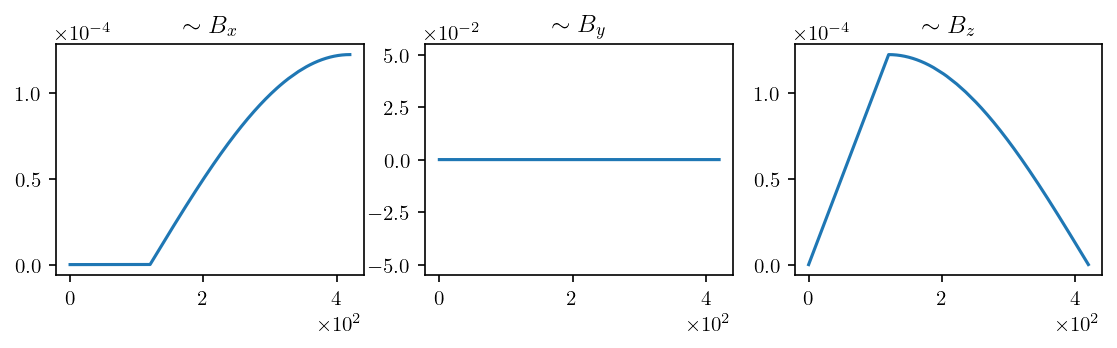

In [10]:
trj_raw = trj = pd.read_csv(os.path.join(data_path,'trj/trj1.csv'), index_col=[0,1])
ctrj_raw = pd.read_csv(os.path.join(data_path,'ctrj/ctrj1.csv'), index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

# Vertex counting

In [ ]:
trj_path = os.path.join(data_path,"trj")
ctrj_path = os.path.join(data_path,"ctrj")
vrt_path = os.path.join(data_path,"vertices")

# Get the number of realizations
_, _, files = next(os.walk(trj_path))
realizations = len(files)

for i in range(1,10+1):
    print("========================================")
    print(f"Working on realization {i}")

    # Importing files
    trj_file = os.path.join(trj_path,f"trj{i}.csv")
    print(f"Opening " + trj_file)
    ctrj_file = os.path.join(ctrj_path,f"ctrj{i}.csv")
    print(f"Opening " + ctrj_file)
    trj_raw = trj = pd.read_csv(trj_file, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrj_file, index_col=[0,1])

    # Doing shit with the vertices
    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    vrt_file = os.path.join(vrt_path,f"vertices{i}.csv")
    v.trj_to_vertices(ctrj_raw.loc[frames[::2]])

    print(f"Saving vertices to " + vrt_file)
    v.vertices.to_csv(vrt_file)
    
    clear_output(wait=True)

In [6]:
vrt_path = os.path.join(data_path,"vertices/")
vertices = aux.getVerticesDict(vrt_path)
counts = aux.getVerticesCount(vertices)
vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
types = vrt_ts.columns.to_list()[1:]
t = vrt_ts["time"].to_numpy()
vrt_counts = vrt_ts[types].to_numpy()

/home/leogabac/.local/lib/python3.8/site-packages/pandas/core/construction.py:580: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


In [8]:
field = t * params["max_field"].magnitude / quench_time.magnitude
params["max_field"]

10 <Unit('millitesla')>

Some visualizations

In [11]:
region_limit = np.round( params["lattice_constant"].magnitude * params["size"] )
last_frame = trj_raw.index.get_level_values("frame").unique()[-1]
ctrj_sel = ctrj_raw.loc[last_frame,:]
v = ice.vertices()
v = v.trj_to_vertices(ctrj_sel)

100%|██████████| 200/200 [00:01<00:00, 144.10it/s]


In [12]:
def drop_shit(ctrj):
    return ctrj.drop(columns={'type','t'})

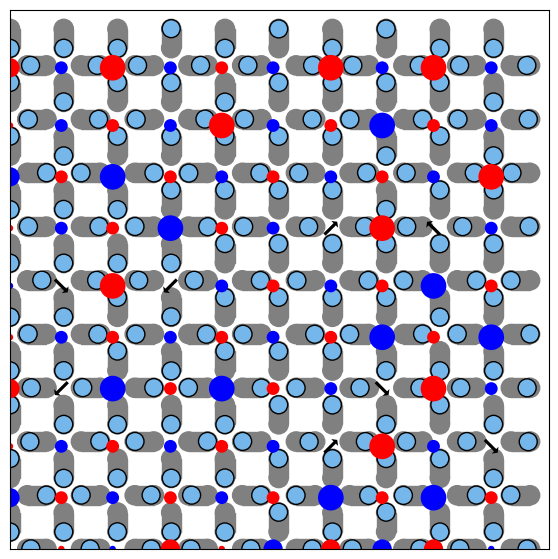

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
ice.draw_frame(drop_shit(ctrj_raw),
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

v.display(ax,dpl_scale=0.5,dpl_width=2.5,circle_scale=0.5)
plt.show()

In [17]:
ctrj_sel.to_csv('../data/test16/weirdshit.csv')

# Order Parameters

In [15]:
# General information

particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"])

trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"])


params["particle"] = particle
params["trap"] = trap


In [23]:
initial_frame = (params['framespersec'] * quench_time).magnitude
last_frame = trj_raw.index.get_level_values("frame").unique()[-1]
analysis_frames = list(range(initial_frame,last_frame+1,1))
framestodo = analysis_frames[::200]
len(framestodo)

30

In [24]:
phi = []
runs = 10

for frame in tqdm(framestodo):

    angle_chirs = [chir.get_chirality_on_realization2(params,data_path,i,sel_frame=frame) for i in range(1,runs+1)]

    phi.append(angle_chirs)

phi

100%|██████████| 30/30 [17:12<00:00, 34.42s/it]


[[100, -100, -100, 100, -100, -100, -100, -100, 6, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 0, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 6, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 24, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 16, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 26, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 4, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 0, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, -2, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, 0, 100],
 [100, -100, -100, 100, -100, -100, -100, -100, -9, 100],
 [31, -34, -41, 41, -43, -35, -31, -44, -14, 33],
 [20, -17, -24, 13, -25, -13, -18, -14, 1, 26],
 [13, -9, -15, 14, -11, -23, -12, -23, -7, 7],
 [9, 1, -5, 0, -1, 1, -1, -5, -5, 1],
 [7, 1, 1, 3, -9, -5, -5, -4, 1, 5],
 [-1, 5, 4, -4, -3, 1, 3, -4, 2, 4],
 [0, 1, 3, 0, 4, 2, 3, 2, -2, -3],
 [0, 4, 3, 0, -1, 2, -1, -1, -2, -3],
 [-3, -2, 5, -4, 5, 1, 0, 3, -4, -2],


In [25]:
cols = ['frame'] + [str(i) for i in range(runs)]
npframe = np.array(framestodo).reshape(-1,1)

In [26]:
phi_df = pd.DataFrame(phi,columns = [str(i) for i in range(runs)])
phi_df['frame'] = npframe
phi_df.to_csv(f"{data_path}/chirality.csv")
phi_df

,0,1,2,3,4,5,6,7,8,9,frame
0,100,-100,-100,100,-100,-100,-100,-100,6,100,2400
1,100,-100,-100,100,-100,-100,-100,-100,0,100,2600
2,100,-100,-100,100,-100,-100,-100,-100,6,100,2800
3,100,-100,-100,100,-100,-100,-100,-100,24,100,3000
4,100,-100,-100,100,-100,-100,-100,-100,16,100,3200
5,100,-100,-100,100,-100,-100,-100,-100,26,100,3400
6,100,-100,-100,100,-100,-100,-100,-100,4,100,3600
7,100,-100,-100,100,-100,-100,-100,-100,0,100,3800
8,100,-100,-100,100,-100,-100,-100,-100,-2,100,4000
9,100,-100,-100,100,-100,-100,-100,-100,0,100,4200


Getting the complementary order parameter

In [27]:
vrt_df = pd.read_csv(os.path.join(data_path,"vertices","vertices1.csv"), index_col=[0,1] )
vrt_frames = vrt_df.index.get_level_values("frame").unique().to_list()
analysis_frames = [frame for frame in vrt_frames if frame > initial_frame][::5]
analysis_frames


[2402,
 2412,
 2422,
 2432,
 2442,
 2452,
 2462,
 2472,
 2482,
 2492,
 2502,
 2512,
 2522,
 2532,
 2542,
 2552,
 2562,
 2572,
 2582,
 2592,
 2602,
 2612,
 2622,
 2632,
 2642,
 2652,
 2662,
 2672,
 2682,
 2692,
 2702,
 2712,
 2722,
 2732,
 2742,
 2752,
 2762,
 2772,
 2782,
 2792,
 2802,
 2812,
 2822,
 2832,
 2842,
 2852,
 2862,
 2872,
 2882,
 2892,
 2902,
 2912,
 2922,
 2932,
 2942,
 2952,
 2962,
 2972,
 2982,
 2992,
 3002,
 3012,
 3022,
 3032,
 3042,
 3052,
 3062,
 3072,
 3082,
 3092,
 3102,
 3112,
 3122,
 3132,
 3142,
 3152,
 3162,
 3172,
 3182,
 3192,
 3202,
 3212,
 3222,
 3232,
 3242,
 3252,
 3262,
 3272,
 3282,
 3292,
 3302,
 3312,
 3322,
 3332,
 3342,
 3352,
 3362,
 3372,
 3382,
 3392,
 3402,
 3412,
 3422,
 3432,
 3442,
 3452,
 3462,
 3472,
 3482,
 3492,
 3502,
 3512,
 3522,
 3532,
 3542,
 3552,
 3562,
 3572,
 3582,
 3592,
 3602,
 3612,
 3622,
 3632,
 3642,
 3652,
 3662,
 3672,
 3682,
 3692,
 3702,
 3712,
 3722,
 3732,
 3742,
 3752,
 3762,
 3772,
 3782,
 3792,
 3802,
 3812,
 3822,

In [28]:
psi= []
for frame in tqdm(analysis_frames):
    results = [chir.get_charge_order_on_frame_on_realization(params,data_path,frame,realization,tol=1.6) for realization in range(1,runs+1) ]
    psi.append(results)

100%|██████████| 600/600 [32:16<00:00,  3.23s/it]


In [29]:
psi_df = pd.DataFrame(psi, columns=[str(i) for i in range(runs)])
psi_df["frame"] = np.array(analysis_frames).reshape(-1,1)
psi_df.to_csv(os.path.join(data_path,"charges.csv"))

# Importing data and plotting

In [30]:
phi_df = pd.read_csv(os.path.join(data_path,"chirality.csv"),index_col=0).applymap(np.abs)
chir_angle = 90/300 * (  phi_df["frame"]/params["framespersec"].magnitude - quench_time.magnitude )

psi_df = pd.read_csv(os.path.join(data_path,"charges.csv"),index_col=0).applymap(np.abs)
charge_angle = 90/300 * (  psi_df["frame"]/params["framespersec"].magnitude - quench_time.magnitude )

datacols = [str(i) for i in range(runs)]
datacols

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [31]:
phi_means = phi_df[datacols].mean(axis=1).to_numpy()
phi_sigmas = phi_df[datacols].std(axis=1).to_numpy()

psi_means = psi_df[datacols].mean(axis=1).to_numpy()
psi_sigmas = psi_df[datacols].std(axis=1).to_numpy()

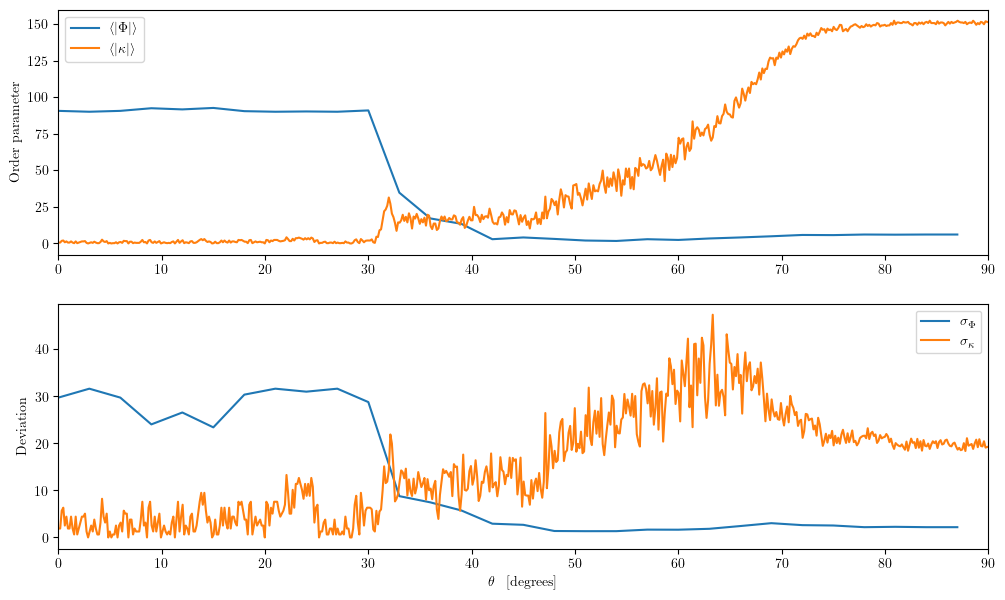

In [32]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

ax = axes[0]
ax.plot(chir_angle,phi_means, label = "$\\langle |\\Phi|\\rangle$")
ax.plot(charge_angle,psi_means, label = "$\\langle |\\kappa|\\rangle$")
ax.set_ylabel("Order parameter")
ax.set_xlim(0,90)
ax.legend()

ax = axes[1]

ax.plot(chir_angle,phi_sigmas, label="$\\sigma_\\Phi$")
ax.plot(charge_angle,psi_sigmas, label="$\\sigma_\\kappa$")

ax.set_xlabel("$\\theta$ \, [degrees]")
ax.set_ylabel("Deviation")

ax.legend()

ax.set_xlim(0,90)

plt.show()

fig.savefig("../data/test12/order_parameters.png",dpi=300)
fig.savefig("../data/test12/order_parameters.pdf")

# Vertex Counting

In [35]:
vrt_path = os.path.join(data_path,"vertices/")
vertices = aux.getVerticesDict(vrt_path)
counts = aux.getVerticesCount(vertices)
vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
types = vrt_ts.columns.to_list()[1:]
t = vrt_ts["time"].to_numpy()
vrt_counts = vrt_ts[types].to_numpy()

/home/leogabac/.local/lib/python3.8/site-packages/pandas/core/construction.py:580: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


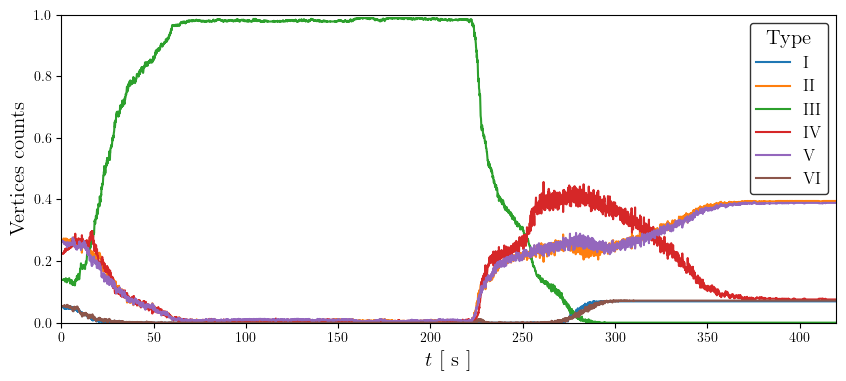

In [36]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(t,vrt_counts[:,0])
ax.plot(t,vrt_counts[:,1])
ax.plot(t,vrt_counts[:,2])
ax.plot(t,vrt_counts[:,3])
ax.plot(t,vrt_counts[:,4])
ax.plot(t,vrt_counts[:,5])

ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black')
ax.set_xlabel("$t$  [ s ] ", fontsize=15)
ax.set_ylabel("Vertices counts", fontsize=15)
ax.set_xlim(0,420)
ax.set_ylim(0,1)
plt.show()

fig.savefig('../data/vertices_full.pdf', bbox_inches='tight')
fig.savefig('../data/vertices_full.jpeg', dpi=300)